In [1]:
import networkx
import networkx as nx 
import numpy as np
import random
import scipy as sp
from scipy.stats import kendalltau
from scipy.sparse import coo_matrix, csr_matrix, eye, identity
import pandas as pd
import seaborn as sb
import copy
import json

from timeit import default_timer as timer
import cProfile
import pstats
import pickle

In [2]:
%run '/Users/janthiel/Desktop/Math Diss/main copy.ipynb'

In [3]:
def generate_graph(n,k):
    # Create a random directed graph
    G = nx.fast_gnp_random_graph(n, 0.7, directed=True)


    # Split the nodes into k subsets
    nodes = list(G.nodes())
    random.shuffle(nodes)
    subsets = [set(nodes[i*n//k:(i+1)*n//k]) for i in range(k)]

    # Remove all edges between different subsets
    for u, v in list(G.edges()):
        for i in range(k):
            if u in subsets[i]:
                for j in range(i+1, k):
                    if v in subsets[j]:
                        G.remove_edge(u, v)
                        break

    # Ensure every node has outdegree of at least 1
    for node in G.nodes():
        if G.out_degree(node) == 0:
            # Choose a random node to connect to, excluding the current node
            other_nodes = list(set(G.nodes()) - {node})
            G.add_edge(node, random.choice(other_nodes))

    # Now, G is a random directed graph that is not strongly connected but every node has outdegree of at least 1

    G = nx.stochastic_graph(G)
    kc_A = nx.adjacency_matrix(G).todense().T
    return G, kc_A

In [4]:
def generate_gnm(n,k):
    # Create a random directed graph
    G = nx.gnm_random_graph(n, k, directed=True)
    degree = 2*k/n
    # Split the nodes into k subsets
    nodes = list(G.nodes())
    random.shuffle(nodes)
    G.remove_nodes_from(nodes[0:int(1/degree)])
    
    # Ensure every node has outdegree of at least 1
    '''for node in G.nodes():
        if G.out_degree(node) == 0:
            # Choose a random node to connect to, excluding the current node
            other_nodes = list(set(G.nodes()) - {node})
            G.add_edge(node, random.choice(other_nodes))'''

    # Now, G is a random directed graph that is not strongly connected but every node has outdegree of at least 1

    G = nx.stochastic_graph(G)
    kc_A = nx.adjacency_matrix(G).todense().T
    return G, kc_A

In [5]:
def find_all_ancestors5_optimized(G, C, G1):
    # Initialize a dictionary to store the ancestors of each node
    ancestors = {node: set() for node in G.nodes}
    predecessors = copy.deepcopy(C)#[set() for node in G1.nodes()]#[set(C[node]) for node in G1.nodes()] # 
    
    for node in nx.topological_sort(G1): #s G1 is DAG so it has s nodes and s(s-1)/2 edges so it has time complexity O(s+s(s-1)/2)
        for pred in G1.predecessors(node): #The total number of predecessors (node x pred(node)) is s(s-1)/2.
            predecessors[node].update(predecessors[pred])
        for original_node in C[node]: #(on average n/s) 
            ancestors[original_node] = predecessors[node]
    
    #u = [list(ancestors[node]) for node in G.nodes()]
    #return u
    return ancestors #the time complexity is O(s+s(s-1)/2) + O(s(s-1)/2 + s*n/s) = O(s+s(s-1)/2) + O(s(s-1)/2 + n)

In [6]:
def T(Graph, alpha):
    n = len(Graph)
    
    A = nx.to_scipy_sparse_array(Graph, format='coo')  # Use coo format directly
    v = pagerank_power(A, p=alpha)
    m = 1/n*(n*v-(1-alpha)/alpha)
    
    C = list(nx.strongly_connected_components(Graph))
    condensed_graph = nx.condensation(Graph, C) # This has time complexity O(V+E)

    u = find_all_ancestors5_optimized(Graph, C, condensed_graph) #the maximum total number of ancestors is n * (s-1)/2 
                                                                #because every every node is part of one SCC, every SCC has on average s(s-1)/(2n) ancestors and every SCC has on average n/s nodes
    row_indices = []
    col_indices = []
    data = [] #try creating a sparse matrix directly (putting 1 for every ancestor and then multiply each row by v[k]/q)

    #for j, ancestors_set in enumerate(u):
    for j, ancestors_set in u.items(): #there are at most n * (s-1)/2 nonzero values so the rest of the algorithm has O(n * (s-1)/2)
        t = len(ancestors_set)
        row_indices.extend([j] * t)
        col_indices.extend(list(ancestors_set))
        data.extend([m[j]] * t)

    #print('we are done loading the matrix')
    M = coo_matrix((data, (row_indices, col_indices)), shape=(n, n))

    eye_matrix = identity(n, format='coo')
    M += ((1 - alpha) / alpha) * eye_matrix
    M = (alpha + 0.0175) * M + (1 - alpha - 0.0175) * A.T

    return M, len(C) #csr_matrix(M)  # Convert to CSR format for efficient arithmetic operations

In [7]:
lessthan1000 = pd.read_pickle('lessthan1000.pkl')

In [22]:
lessthan1000.rename(columns={'number of nodes': 'old nodes', 'number of degrees': 'number of edges', 'time for Approximatation matrix':'time for Approximation matrix', 'Minimum time for PPM': 'old Minimum time for PPM'}, inplace=True)

In [24]:
lessthan1000['number of nodes'] = lessthan1000['old nodes'] - (lessthan1000['old nodes']/(2*lessthan1000['number of edges']))*lessthan1000['old nodes']
lessthan1000['Minimum time for PPM'] = (lessthan1000['old Minimum time for PPM'] / lessthan1000['old nodes']) * lessthan1000['number of nodes']
lessthan1000

,old nodes,number of edges,number of SCC,time for Approximation matrix,old Minimum time for PPM,NDCG,number of nodes,Minimum time for PPM
0,100.0,300.0,13.0,0.023271,5.003146,0.971272,83.333333,4.169288
1,200.0,1000.0,3.0,0.044472,5.048185,0.983041,180.000000,4.543366
2,300.0,1200.0,9.0,0.120680,3.536914,0.959871,262.500000,3.094800
3,400.0,1600.0,12.0,0.238628,14.782915,0.958084,350.000000,12.935050
4,500.0,2500.0,5.0,0.466221,55.653738,0.961248,450.000000,50.088364
...,...,...,...,...,...,...,...,...
995,230.0,920.0,9.0,0.064024,50.941080,0.970036,201.250000,44.573445
996,977.0,4885.0,14.0,2.169591,114.165455,0.946523,879.300000,102.748910
997,967.0,3868.0,33.0,1.785828,190.077019,0.935557,846.125000,166.317391
998,513.0,1539.0,70.0,0.330610,86.191331,0.942211,427.500000,71.826109


In [26]:
from sklearn.metrics import ndcg_score

def fill_dataframe(dataframe, nodes, iterations):
        for i in range(24):
                n = random.randint(1000, nodes)
                k = random.randint(3, 6)
                k *= n
                F, kc_B = generate_gnm(n,k)
                n = len(F)
                start = timer()
                A, s = T(F, 0.85)
                end = timer()
                t1 = end - start
                A = A.toarray()
                p = []
                t = []
                for j in np.random.randint(0, n, iterations): #change back to n
                        personalise = np.zeros(n)
                        personalise[j]=1
                        start = timer()
                        Bv = pagerank_power(kc_B.T, p=0.85, max_iter=30, personalize=personalise, tol=1e-8)
                        end = timer()
                        t.append(end-start)
                        p.append(ndcg_score(Bv.reshape(1, -1), A[:,j].reshape(1, -1)))

                dataframe.loc[len(dataframe.index)] = [n, k, s, t1, n*sum(t)/iterations, sum(p)/iterations]
                print(i)
        return dataframe


In [2]:
from sklearn.metrics import ndcg_score
x = np.array([0, 0.4, 0.1, 0.2, 0.3])
y = np.array([0, 0.4, 0, 0.3, 0.2])
ndcg_score(y.reshape(1, -1), x.reshape(1, -1))

NameError: name 'np' is not defined

In [4]:
1+3

4

In [98]:
fill_dataframe(lessthan10k, 10000, 10)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


,number of nodes,number of edges,number of SCC,time for approximation,Minimum time for PPM,NDCG
0,6066.0,18198.0,664.0,25.066561,7456.452021,0.899616
1,3212.0,12848.0,128.0,8.374963,548.122431,0.903877
2,4458.0,17832.0,180.0,12.890601,2473.815833,0.887978
3,9100.0,27300.0,1010.0,81.438027,27016.095435,0.872014
4,1152.0,5760.0,15.0,0.847149,19.475222,0.944366
...,...,...,...,...,...,...
95,6065.0,30325.0,81.0,19.626885,6565.093622,0.923080
96,2960.0,8880.0,313.0,5.216167,455.714440,0.877227
97,3349.0,20094.0,21.0,7.016397,567.752446,0.937594
98,8194.0,40970.0,120.0,44.236635,13551.390956,0.912607


In [149]:
lessthan10k['NDCG'].std()

In [138]:
lessthan10k.to_pickle('lessthan10k.pkl')

In [111]:
lessthan10k.loc[:, 'Minimum time for PPM'].mean()

Text(0.5, 1.0, 'Number of edges compared to NDCG')

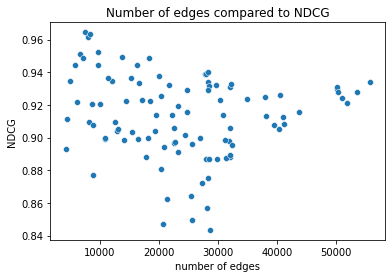

In [105]:
sb.scatterplot(x = lessthan10k['number of edges'], y=lessthan10k['NDCG']).set_title('Number of edges compared to NDCG')

In [241]:
from sklearn.metrics import ndcg_score
# we have groud-truth relevance of some answers to a query:
true_relevance = fast_powerrecommend_Matrix2(kc_B,0.15)
# we predict some scores (relevance) for the answers
scores = T(F, 0.85).toarray()
ndcg_score(true_relevance, scores)

In [750]:
l = []
for i in range(1,50):
    n = random.randint(50, 100)
    k = random.randint(10, n)
    F, kc_B = generate_graph(n,k)
    A = T(F, 0.85).toarray()
    #B = Fast(F,0.85).toarray()
    #B = L(F, kc_B, 0.85)
    #B = N(F, kc_B, 0.85)
    B = fast_powerrecommend_Matrix2(kc_B, 0.15)#fast_powerrecommend_Matrix2(kc_A, 0.15)
    #U = (sp.stats.rankdata(A, axis=0) - sp.stats.rankdata(B, axis=0))
    #U = U[U>0]#
    l.append(sp.stats.kendalltau(A,B)[0])

In [751]:
sum(l)/50

In [16]:
edges_path = '/Users/janthiel/Downloads/facebook_large/musae_facebook_edges.csv'
targets_path = '/Users/janthiel/Downloads/facebook_large/musae_facebook_target.csv'
features_path = '/Users/janthiel/Downloads/facebook_large/musae_facebook_features.json'
edges = pd.read_csv(edges_path)
targets = pd.read_csv(targets_path)
targets.index = targets.id
with open(features_path) as json_data:
    features = json.load(json_data)
fb_graph = networkx.convert_matrix.from_pandas_edgelist(edges, "id_1", "id_2", create_using=networkx.MultiDiGraph())
fb_graph = networkx.stochastic_graph(fb_graph)
fb_A = networkx.to_scipy_sparse_array(fb_graph, format='lil')

In [16]:
ch_graph = nx.read_edgelist("/Users/janthiel/Downloads/SNAP_Graphs/cit-HepTh.txt",create_using=nx.DiGraph(), nodetype = int)
ch_graph = networkx.stochastic_graph(ch_graph)
ch_A = networkx.to_scipy_sparse_array(ch_graph, format='lil')

In [7]:
from sklearn.metrics import ndcg_score

def fill_dataframe(dataframe, graph, adjacancy_matrix, iterations):
        F = graph
        kc_B = adjacancy_matrix
        n = len(F)
        k = len(graph.edges())
        start = timer()
        A, s = T(F, 0.85)
        end = timer()
        t1 = end - start
        A = A.toarray()
        p = []
        t = []
        i = 1
        for j in np.random.randint(0, n, iterations): #change back to n
                personalise = np.zeros(n)
                personalise[j]=1
                start = timer()
                Bv = pagerank_power(kc_B.T, p=0.85, max_iter=30, personalize=personalise, tol=1e-8)
                end = timer()
                t.append(end-start)
                p.append(ndcg_score(Bv.reshape(1, -1), A[:,j].reshape(1, -1)))
                print(i)
                i+=1 
        dataframe.loc[len(dataframe.index)] = [n, k, s, t1, n*sum(t)/iterations, sum(p)/iterations]
        return dataframe

In [12]:
#RGdf = pd.DataFrame(columns=['number of nodes', 'number of edges', 'number of SCC', 'time for approximation', 'Minimum time for PPM', 'NDCG'])

In [17]:
fill_dataframe(RGdf, ch_graph, ch_A, 100)

IndexError: index 9304045 is out of bounds for axis 0 with size 27770

In [180]:
T(gt_graph, 0.85)

In [33]:
cm_graph.nodes()

NodeView((81626, 11894, 16246, 16322, 18914, 19729, 29574, 33045, 47998, 49453, 52148, 53171, 57478, 58947, 65889, 69807, 71241, 71586, 73498, 74989, 77976, 82175, 82686, 83197, 86550, 87044, 90037, 91476, 93858, 96866, 100206, 104817, 104841, 105429, 106876, 107009, 107254, 94, 14598, 45089, 45620, 46269, 46745, 57427, 59913, 62327, 67665, 93928, 95053, 104056, 4750, 209, 1631, 1895, 5087, 5489, 6088, 8536, 9412, 10099, 11699, 23802, 32021, 34036, 36397, 38677, 46144, 49824, 49895, 50279, 51800, 52287, 57702, 58255, 59122, 60010, 63527, 64131, 64164, 64623, 66863, 67236, 70050, 70665, 72119, 74174, 78851, 80341, 82037, 82247, 83259, 83562, 83824, 85287, 88584, 88748, 89659, 89766, 92915, 95372, 95641, 96901, 101244, 104422, 105341, 105877, 107534, 7930, 14502, 20850, 44858, 52169, 62552, 82995, 98707, 105046, 19136, 1265, 44830, 46918, 60397, 61080, 79490, 7471, 19503, 24345, 47236, 48536, 20831, 15263, 47678, 51555, 86311, 91211, 7900, 14074, 14609, 17522, 23175, 25430, 31712, 32276,

In [15]:
RGdf.to_pickle('realGraphs')

In [20]:
ch_graph.relabel()

NodeView((1001, 9304045, 9308122, 9309097, 9311042, 9401139, 9404151, 9407087, 9408099, 9501030, 9503124, 9504090, 9504145, 9505025, 9505054, 9505105, 9505162, 9506048, 9506112, 9506144, 9507050, 9507158, 9508094, 9508155, 9510142, 9510225, 9510234, 9511030, 9511171, 9601108, 9602022, 9602114, 9603003, 9603150, 9603161, 9603167, 9605184, 9605222, 9606017, 9606040, 9607163, 9607207, 9608086, 9609070, 9609071, 9609239, 9611137, 9612108, 9701162, 9702094, 9702155, 9702198, 9703082, 9703166, 9704097, 9705030, 9705044, 9705104, 9705220, 9706005, 9707014, 9707042, 9707049, 9710230, 9711036, 9711104, 9712028, 9712042, 9802194, 9805056, 9805206, 9806094, 9810188, 9811217, 9905036, 9907041, 9908007, 9908144, 9909108, 9909120, 9909229, 9910238, 9910248, 9910268, 9204040, 9203084, 9204035, 9205041, 9207049, 9207111, 9301042, 9301043, 9201015, 9201040, 9201047, 9202046, 9202059, 9202092, 9203008, 9203031, 9204037, 9204046, 9205046, 9205060, 9205062, 9205068, 9206023, 9206051, 9206078, 9207016, 920

In [28]:
list(ch_graph.nodes)

KeyboardInterrupt: 

In [22]:
ch_mapping = {node: ch_graph.nodes[node] for node in ch_graph.nodes}

In [23]:
ch_mapping

{1001: {}, 1002: {}, 1003: {}, 1004: {}, 1005: {}, 1006: {}, 1007: {}, 1008: {
}, 1009: {}, 1010: {}, 1011: {}, 1012: {}, 1013: {}, 1014: {}, 1015: {}, 1016:
 {}, 1017: {}, 1018: {}, 1019: {}, 1020: {}, 1021: {}, 1022: {}, 1023: {}, 102
4: {}, 1025: {}, 1026: {}, 1027: {}, 1028: {}, 1029: {}, 1030: {}, 1031: {}, 1
032: {}, 1033: {}, 1034: {}, 1035: {}, 1036: {}, 1037: {}, 1038: {}, 1039: {},
 1040: {}, 1041: {}, 1042: {}, 1044: {}, 1045: {}, 1046: {}, 1047: {}, 1048: {
}, 1049: {}, 1050: {}, 1051: {}, 1052: {}, 1053: {}, 1054: {}, 1055: {}, 1056:
 {}, 1057: {}, 1060: {}, 1061: {}, 1062: {}, 1063: {}, 1064: {}, 1065: {}, 106
6: {}, 1067: {}, 1068: {}, 1069: {}, 1070: {}, 1071: {}, 1072: {}, 1073: {}, 1
074: {}, 1075: {}, 1076: {}, 1077: {}, 1080: {}, 1081: {}, 1082: {}, 1083: {},
 1084: {}, 1085: {}, 1086: {}, 1087: {}, 1088: {}, 1089: {}, 1090: {}, 1091: {
}, 1092: {}, 1093: {}, 1094: {}, 1095: {}, 1096: {}, 1097: {}, 1098: {}, 1100:
 {}, 1101: {}, 1102: {}, 1103: {}, 1105: {}, 1106: {

In [25]:
ch_mapping[1001]

KeyError: 0